In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error # MSE
from sklearn.metrics import mean_absolute_error # MAE
from sklearn.metrics import r2_score # R2

In [2]:
def data_handle(filename):
    dataset = pd.read_csv(filename)
    dataset = dataset.rename(
        columns={'Measured Depth m': 'DEPTH', 'Weight on Bit kkgf': 'WOB', 'Average Standpipe Pressure kPa': 'SPP',
                 'Average Surface Torque kN.m': 'ST',
                 'Rate of Penetration m/h': 'ROP', 'Average Rotary Speed rpm': 'RPM', 'Mud Flow In L/min': 'MFI',
                 'Mud Density In g/cm3': 'MDI', 'Diameter mm': 'DIA',
                 'Average Hookload kkgf': 'HookLoad', 'Hole Depth (TVD) m': 'TVD', 'USROP Gamma gAPI': 'UiSGamma'})
    dataset.drop(['Unnamed: 0'], axis=1, inplace=True)
    dataset.drop(['TVD'], axis=1, inplace=True)
    col = list(dataset)
    col = col[0:-1]
    col.insert(13, col.pop(col.index('ROP')))
    dataset = dataset.loc[0:, col]
    df = pd.DataFrame()
    df = df.append(dataset, ignore_index=True)
    del df['Unnamed: 0.1']
    # del df['FORMATION']
    # del df['DIA']
    return df

In [59]:
def evaluate_model(rf,df_1,df_2,pycaret = False):
#     if pycaret:
#         reg = setup(data=df_1, numeric_features=['DIA'], target='ROP')  # 默认为百分之七十的训练 百分之三十的测试
#         best_model = compare_models()  # 选取模型n_select= n 选择前n个auc最大的模型 默认为1
#         predict_et = predict_model(best_model, data = df_2)
#         print(predict_et)
#         print('etmodel rmse:' ,np.sqrt(mean_squared_error(predict_et['ROP'], predict_et['Label'])))
#         print('etmodel mae:' ,mean_absolute_error(predict_et['ROP'], predict_et['Label']))
#         print('etmodel r2:' ,r2_score(predict_et['ROP'],predict_et['Label']))
#         tuned_model, tuner = tune_model(best_model, return_tuner=True)
#         predict_tuned = predict_model(tuned_model, data = df_2)
#         print(predict_tuned)
#         print('tunedetmodel rmse:' ,np.sqrt(mean_squared_error(predict_tuned['ROP'], predict_tuned['Label'])))
#         print('tunedetmodel mae:' ,mean_absolute_error(predict_tuned['ROP'], predict_tuned['Label']))
#         print('tunedetmodel r2:' ,r2_score(predict_tuned['ROP'],predict_tuned['Label']))
#         return predict_et['ROP'],predict_tuned['ROP'],predict_et['Label'],predict_tuned['Label']
#     else:
    X = df_1.iloc[:, 0:10] 
    y = df_1.iloc[:, -1]
    #train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
    rf.fit(X,y)
    X_2 = df_2.iloc[:, 0:10]
    y_2 = df_2.iloc[:, -1]

    train_predictions = rf.predict(X)
    test_predictions = rf.predict(X_2)
    return y,y_2,train_predictions,test_predictions


In [60]:
data_list = []
df_9ad = data_handle('USROP_A 0 N-NA_F-9_Ad_F.csv')
df_7d = data_handle('USROP_A 1 N-S_F-7d_F.csv')
df_14d = data_handle('USROP_A 2 N-SH_F-14d_F.csv')
df_15sd = data_handle('USROP_A 4 N-SH_F-15Sd_F.csv')
df_5d = data_handle('USROP_A 5 N-SH_F-5d_F.csv')
df_9d = data_handle('USROP_A 6 N-SH_F-9d_F.csv')

data_list.append(df_9ad)
data_list.append(df_7d)
data_list.append(df_14d)
data_list.append(df_15sd)
data_list.append(df_5d)
data_list.append(df_9d)
name_list = ['df_9ad','df_7d','df_14d','df_15sd','df_5d','df_9d']

In [61]:
path = 'result.xlsx'
writer = pd.ExcelWriter(path)

In [100]:
# test for one well
rf = RandomForestRegressor(n_estimators=200)
# define a well for training and validation
well_train = data_list[0]
# add one more well for training
well_train = well_train.append(data_list[1])
well_train = well_train.append(data_list[2])
well_train = well_train.append(data_list[3])
# define a well for testing
well_test = data_list[5]
y, y_2, train_predictions, test_predictions = evaluate_model(rf, well_train, well_test)

test_rmse = np.sqrt(mean_squared_error(y_2, test_predictions))
test_mae = mean_absolute_error(y_2, test_predictions)
test_r2 = r2_score(y_2, test_predictions)
print('train_rmse:', train_rmse)
print('train_mae:', train_mae)
print('train_r2:', train_r2)
print('test_rmse:', test_rmse)
print('test_mae:', test_mae)
print('test_r2:', test_r2)

train_rmse: 0.004536854702945772
train_mae: 0.00017725137170621576
train_r2: 0.9999999486801616
test_rmse: 17.708125718333395
test_mae: 8.317342067661345
test_r2: 0.21815487734497052


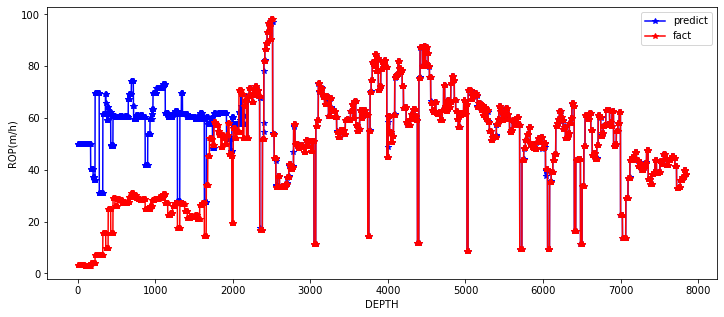

In [101]:
# results of predicted ROP in a testing well
plt.figure(figsize=(12,5))
plt.plot(test_predictions, color='blue', marker='*', linestyle='-', label='predict')
plt.plot(y_2, color='red', marker='*', linestyle='-', label='fact')
plt.legend()
plt.xlabel('DEPTH')
plt.ylabel('ROP(m/h)')
plt.show()

In [6]:
# Results for every well cross evaluation
rf = RandomForestRegressor()
for index_i,i in enumerate(name_list):
    data_pd = pd.DataFrame(columns=['well_name', 'result'])
    data_pd['well_name'] = name_list
    for index_k,k in enumerate(name_list):
        traintimes =0
        max_r2 = 0
        print(index_i,index_k)
        if index_i == index_k:
            continue
        else:
            while(traintimes < 3):
                print(traintimes)
                traintimes = traintimes+1
                y, y_2, train_predictions, test_predictions = evaluate_model(rf, data_list[index_i], data_list[index_k])
                train_rmse = np.sqrt(mean_squared_error(y, train_predictions))
                train_mae = mean_absolute_error(y, train_predictions)
                train_r2 = r2_score(y, train_predictions)

                test_rmse = np.sqrt(mean_squared_error(y_2, test_predictions))
                test_mae = mean_absolute_error(y_2, test_predictions)
                test_r2 = r2_score(y_2, test_predictions)
                print('train_rmse:', train_rmse)
                print('train_mae:', train_mae)
                print('train_r2:', train_r2)
                print('test_rmse:', test_rmse)
                print('test_mae:', test_mae)
                print('test_r2:', test_r2)
                if (test_r2 > max_r2):
                    max_r2 = test_r2
                    resultstr = ('train_rmse:' + str(train_rmse) + '\n' + 'train_mae:' + str(train_mae) + '\n' +
                                 'train_r2:' + str(train_r2) + '\n' + 'test_rmse:' + str(test_rmse) + '\n' +
                                 'test_mae:' + str(test_mae) + '\n' + 'test_r2:' + str(test_r2) + '\n')
                    for j in range(data_pd.shape[0]):
                        if data_pd['well_name'][j] == k:
                            data_pd['result'][j] = resultstr
                data_pd.to_excel(writer, sheet_name=str(i), index=False)
writer.save()

0
train_rmse: 0.0195499070977854
train_mae: 0.0011522300340620329
train_r2: 0.9999973319016702
test_rmse: 1.3912151450954087
test_mae: 0.41526112839368007
test_r2: 0.992464290159703
1
train_rmse: 0.016995449074590583
train_mae: 0.0010891056569334516
train_r2: 0.9999979835951928
test_rmse: 1.2872807265114268
test_mae: 0.37660824628756023
test_r2: 0.9935481819986036
2
train_rmse: 0.013335466314851566
train_mae: 0.0009851317381209554
train_r2: 0.9999987585510985
test_rmse: 1.199327293102147
test_mae: 0.35714229776403233
test_r2: 0.9943997036626233
0
train_rmse: 0.018521427018896152
train_mae: 0.001166974673084282
train_r2: 0.9999976052436998
test_rmse: 0.22276912825222317
test_mae: 0.10861125536772467
test_r2: 0.9997188285543648
1
train_rmse: 0.011623950220180092
train_mae: 0.0009705052850438783
train_r2: 0.9999990567649772
test_rmse: 0.23238945256586377
test_mae: 0.11105728920511415
test_r2: 0.9996940193034979
2
train_rmse: 0.014732557328768018
train_mae: 0.0010341369969599848
train_r2: 

train_rmse: 0.012750275538976839
train_mae: 0.00033691763787257876
train_r2: 0.9999979353210044
test_rmse: 0.7410738589786697
test_mae: 0.38555539838061736
test_r2: 0.9961661472979639
1
train_rmse: 0.014395333688419715
train_mae: 0.0003971862034230672
train_r2: 0.9999973681758235
test_rmse: 0.7835403140103365
test_mae: 0.4045645151674725
test_r2: 0.99571416815247
2
train_rmse: 0.01166810376340983
train_mae: 0.000361922685615732
train_r2: 0.9999982709244706
test_rmse: 0.6489188548811405
test_mae: 0.31691771252975726
test_r2: 0.997060366273819
0
train_rmse: 0.015427481766041548
train_mae: 0.00037393791670589134
train_r2: 0.9999969772412787
test_rmse: 2.0870969962955654
test_mae: 1.4014269040815654
test_r2: 0.9830401955613146
1
train_rmse: 0.01762915882422241
train_mae: 0.0003950132356040075
train_r2: 0.9999960529140806
test_rmse: 2.126779560647848
test_mae: 1.5013219631884005
test_r2: 0.9823891414101779
2
train_rmse: 0.016815254289280383
train_mae: 0.00038802406278916503
train_r2: 0.9999